## Creating RFM Table 

#### Transaction data alone is sufficient to create an RFM score table by extracting the necessary information.

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 

from datetime import datetime, date

In [2]:
trans = pd.read_csv(r"F:\Data Analytics\2.RFM Analysis project\9.Transactions_Cleaned")

In [3]:
trans.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,list_price,standard_cost,product_first_sold_date,Profit
0,1,2,2950,2017-02-25,0.0,Approved,Solex,Standard,medium,medium,71.49,53.62,41245.0,17.87
1,2,3,3120,2017-05-21,1.0,Approved,Trek Bicycles,Standard,medium,large,2091.47,388.92,41701.0,1702.55
2,3,37,402,2017-10-16,0.0,Approved,OHM Cycles,Standard,low,medium,1793.43,248.82,36361.0,1544.61
3,4,88,3135,2017-08-31,0.0,Approved,Norco Bicycles,Standard,medium,medium,1198.46,381.10,36145.0,817.36
4,5,78,787,2017-10-01,1.0,Approved,Giant Bicycles,Standard,medium,large,1765.30,709.48,42226.0,1055.82


In [4]:
print("Total records (rows) in the Transaction Dataset : {}".format(trans.shape[0]))
print("Total features (columns) in the Transaction Dataset : {}".format(trans.shape[1]))

Total records (rows) in the Transaction Dataset : 19803
Total features (columns) in the Transaction Dataset : 14


In [5]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19803 entries, 0 to 19802
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           19803 non-null  int64  
 1   product_id               19803 non-null  int64  
 2   customer_id              19803 non-null  int64  
 3   transaction_date         19803 non-null  object 
 4   online_order             19803 non-null  float64
 5   order_status             19803 non-null  object 
 6   brand                    19803 non-null  object 
 7   product_line             19803 non-null  object 
 8   product_class            19803 non-null  object 
 9   product_size             19803 non-null  object 
 10  list_price               19803 non-null  float64
 11  standard_cost            19803 non-null  float64
 12  product_first_sold_date  19803 non-null  float64
 13  Profit                   19803 non-null  float64
dtypes: float64(5), int64(3

In [6]:
#converting Transaction date datatype to datetime 
trans['transaction_date'] = pd.to_datetime(trans['transaction_date'])

# RFM Table

#### * Recency (R): Who have purchased recently? Number of days since last purchase (least recency)
#### * Frequency (F): Who has purchased frequently? It means the total number of purchases. ( high frequency)
#### * Monetary Value(M): Who have high purchase amount? It means the total money customer spent (high monetary value)

In [7]:
trans.columns

Index(['transaction_id', 'product_id', 'customer_id', 'transaction_date',
       'online_order', 'order_status', 'brand', 'product_line',
       'product_class', 'product_size', 'list_price', 'standard_cost',
       'product_first_sold_date', 'Profit'],
      dtype='object')

In [8]:
#latest transaction date 
latest_date = trans['transaction_date'].max().date()
comparison_date = datetime.strptime(str(latest_date), "%Y-%m-%d")
comparison_date

datetime.datetime(2017, 12, 30, 0, 0)

In [9]:
# Creating a RFM table that will contain all the values for recency , frequency and Monetray data. 
RFM = trans.groupby(['customer_id']).agg({'transaction_date': lambda date : (comparison_date - date.max()).days,
                                                            'product_id' : lambda prod_id : len(prod_id), 
                                                            'Profit' : lambda p : sum(p)})

In [10]:
# Renaming column names to appropiate names
RFM.rename(columns={'transaction_date' : 'recency', 'product_id' : 'frequency','Profit' : 'monetary'} , inplace=True)

In [11]:
RFM

,recency,frequency,monetary
customer_id,,,
1,7,11,3018.090000
2,128,3,2226.260000
3,102,8,3362.810000
4,195,2,220.570000
5,16,6,2394.940000
...,...,...,...
3497,52,3,1648.320000
3498,127,6,3147.330000
3499,51,7,4955.250000


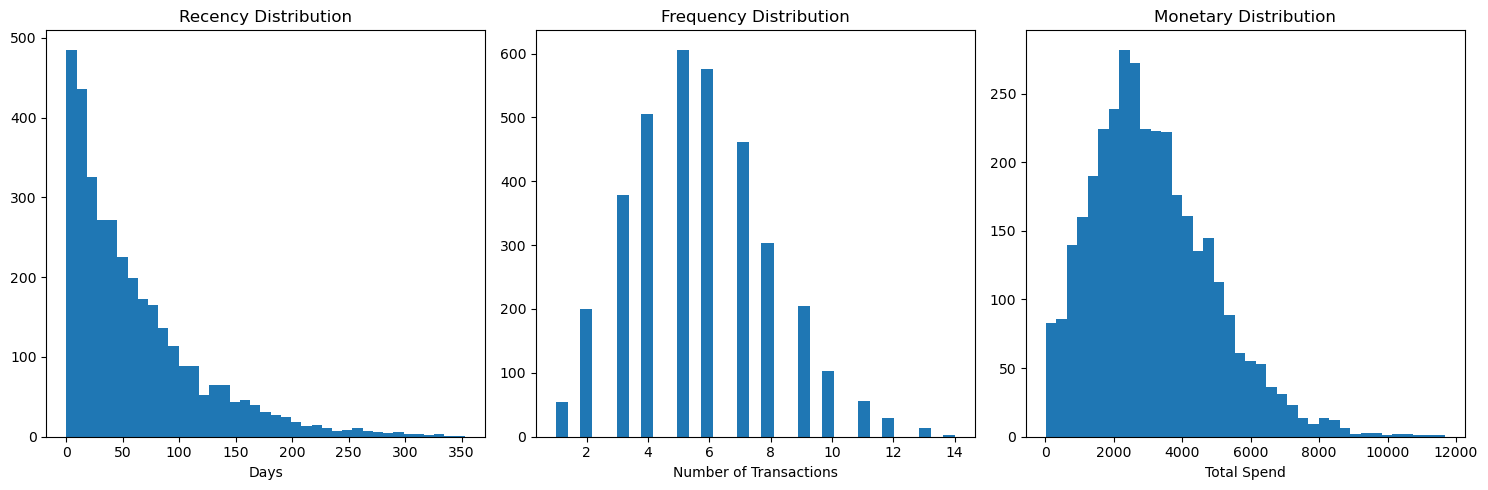

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.hist(RFM['recency'], bins='auto')
ax1.set_title('Recency Distribution')
ax1.set_xlabel('Days')

ax2.hist(RFM['frequency'], bins='auto')
ax2.set_title('Frequency Distribution')
ax2.set_xlabel('Number of Transactions')

ax3.hist(RFM['monetary'], bins='auto')
ax3.set_title('Monetary Distribution')
ax3.set_xlabel('Total Spend')

plt.tight_layout()

## K-mean Clustering 

**K-means clustering is an unsupervised machine learning algorithm used to partition a dataset into K distinct, non-overlapping subgroups (clusters). In this project, we applied K-means to our RFM (Recency, Frequency, Monetary) data to segment customers**

In [13]:
# Standardize features before K-Means clustering to ensure equal weight for all variables
# and improve the clustering algorithm's performance by handling different scales.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(RFM) 

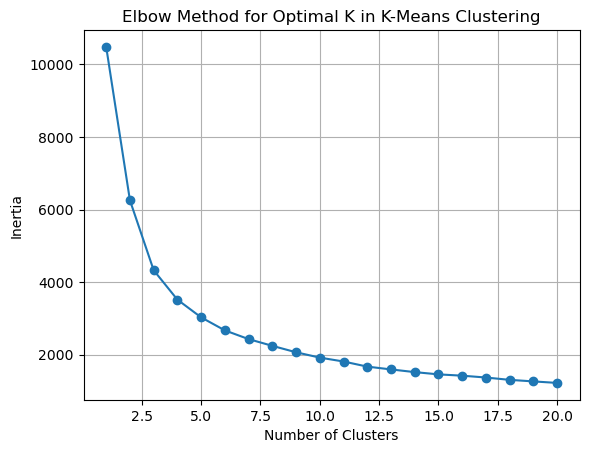

In [14]:
from sklearn.cluster import KMeans

inertia = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i,random_state=42) 
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 21), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K in K-Means Clustering')
plt.grid(True)
plt.show()

#### based on the graph we can say that 4 or 5 cluster are optimal for the analysis and i am going with 4 cluster 

In [15]:
#labeling the clusters 
kmeans = KMeans(n_clusters=4, random_state=42) 
kmeans.fit(data_scaled)
RFM['clusters'] = kmeans.labels_ + 1 

In [16]:
RFM

,recency,frequency,monetary,clusters
customer_id,,,,
1,7,11,3018.090000,2
2,128,3,2226.260000,4
3,102,8,3362.810000,1
4,195,2,220.570000,4
5,16,6,2394.940000,1
...,...,...,...,...
3497,52,3,1648.320000,3
3498,127,6,3147.330000,1
3499,51,7,4955.250000,1


In [17]:
#understanding how each cluster is performing 
grouped = RFM.groupby(['clusters'])[['recency', 'frequency', 'monetary']].mean().round(2).sort_values(by= 'monetary', ascending = False)
print(grouped)

          recency  frequency  monetary
clusters                              
2           34.47       9.00   5849.62
1           43.97       6.40   3502.24
4          173.57       3.56   1830.10
3           45.04       3.88   1752.11


In [18]:
def cluster_title(row):
    if row['clusters'] == 1:
        return 'Gold_customer'
    elif row['clusters'] == 2:
        return 'Platinum_customer'
    elif row['clusters'] == 3:
        return 'Silver_customer'
    else:
        return 'Bronze_customer'


In [19]:
RFM['customer_segments']= RFM.apply(cluster_title, axis=1) 

In [20]:
RFM

,recency,frequency,monetary,clusters,customer_segments
customer_id,,,,,
1,7,11,3018.090000,2,Platinum_customer
2,128,3,2226.260000,4,Bronze_customer
3,102,8,3362.810000,1,Gold_customer
4,195,2,220.570000,4,Bronze_customer
5,16,6,2394.940000,1,Gold_customer
...,...,...,...,...,...
3497,52,3,1648.320000,3,Silver_customer
3498,127,6,3147.330000,1,Gold_customer
3499,51,7,4955.250000,1,Gold_customer


In [21]:
result = RFM['customer_segments'].value_counts()

<Axes: ylabel='customer_segments'>

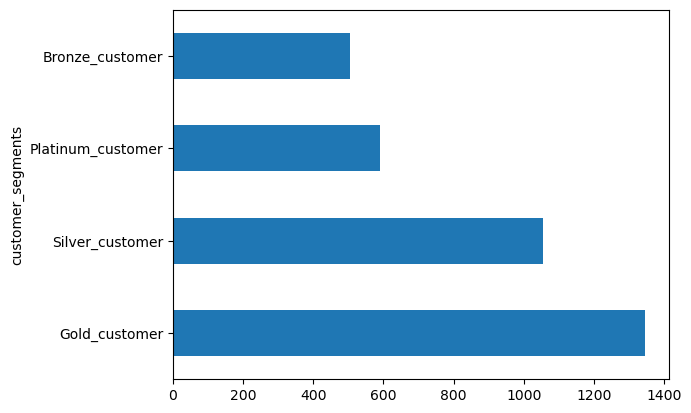

In [22]:
result.plot(kind = 'barh')

### Segmenting customers into four groups has simplified our understanding of the overall customer base for an Australian automobile bike company. Based on these segments and available datasets, we will conduct exploratory data analysis (EDA) and sales analysis to derive insights and create a meaningful dashboard.

## Combining Datasets 

In [23]:
# importing other dataset 
customer_demographics = pd.read_csv(r"F:\Data Analytics\2.RFM Analysis project\6.CustomerDemographic_Cleaned")
Customer_address = pd.read_csv(r"F:\Data Analytics\2.RFM Analysis project\8.CustomerAddress_Cleaned")

In [24]:
customer_demographics.head(5)

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,Age
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,70
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,43
2,3,Arlin,Dearle,Male,61,1954-01-20,Recruiting Manager,Property,Mass Customer,N,Yes,15.0,70
3,4,Talbot,NaN,Male,33,1961-10-03,Missing,IT,Mass Customer,N,No,7.0,62
4,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Missing,Affluent Customer,N,Yes,8.0,47


In [25]:
Customer_address.head(5)

,customer_id,address,postcode,state,country,property_valuation
0,1,060 Morning Avenue,2016,NSW,Australia,10
1,2,6 Meadow Vale Court,2153,NSW,Australia,10
2,4,0 Holy Cross Court,4211,QLD,Australia,9
3,5,17979 Del Mar Point,2448,NSW,Australia,4
4,6,9 Oakridge Court,3216,VIC,Australia,9


In [26]:
#Combining all dataset in one for easire analyis and better overall data view 

transactions_rfm = pd.merge(trans, RFM, on='customer_id', how='left')
transactions_rfm_demo = pd.merge(transactions_rfm, customer_demographics, on='customer_id', how='left')
df = pd.merge(transactions_rfm_demo, Customer_address, on='customer_id', how='left')

In [27]:
#converting some dtypes just for memory efficiency 
categorical_cols = ['order_status', 'brand', 'product_line', 'product_class', 'product_size', 'clusters', 'customer_segments', 'gender', 'state']
boolean_cols = ['online_order', 'owns_car']
date_col = 'DOB'

df[categorical_cols] = df[categorical_cols].astype('category')
df[boolean_cols] = df[boolean_cols].astype('bool')
df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d') 

In [28]:
#checking duplicates 
df[df.duplicated].count()

transaction_id                         0
product_id                             0
customer_id                            0
transaction_date                       0
online_order                           0
order_status                           0
brand                                  0
product_line                           0
product_class                          0
product_size                           0
list_price                             0
standard_cost                          0
product_first_sold_date                0
Profit                                 0
recency                                0
frequency                              0
monetary                               0
clusters                               0
customer_segments                      0
first_name                             0
last_name                              0
gender                                 0
past_3_years_bike_related_purchases    0
DOB                                    0
job_title       

In [29]:
df.head(5)

,transaction_id,product_id,customer_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,...,wealth_segment,deceased_indicator,owns_car,tenure,Age,address,postcode,state,country,property_valuation
0,1,2,2950,2017-02-25,False,Approved,Solex,Standard,medium,medium,...,Mass Customer,N,True,10.0,69.0,984 Hoepker Court,3064.0,VIC,Australia,6.0
1,2,3,3120,2017-05-21,True,Approved,Trek Bicycles,Standard,medium,large,...,Mass Customer,N,True,10.0,45.0,4 Shopko Circle,2196.0,NSW,Australia,5.0
2,3,37,402,2017-10-16,False,Approved,OHM Cycles,Standard,low,medium,...,Affluent Customer,N,True,22.0,47.0,586 Miller Parkway,2835.0,NSW,Australia,1.0
3,4,88,3135,2017-08-31,False,Approved,Norco Bicycles,Standard,medium,medium,...,Mass Customer,N,True,16.0,62.0,1617 Harper Parkway,2096.0,NSW,Australia,10.0
4,5,78,787,2017-10-01,True,Approved,Giant Bicycles,Standard,medium,large,...,Affluent Customer,N,True,2.0,27.0,0601 Stephen Place,2292.0,NSW,Australia,7.0


In [30]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
transaction_id,19803.0,9993.97965,1.0,4988.5,9995.0,15000.5,20000.0,5776.499961
product_id,19803.0,45.815937,0.0,18.0,45.0,72.0,100.0,30.569841
customer_id,19803.0,1739.294955,1.0,858.0,1738.0,2615.0,5034.0,1011.946353
transaction_date,19803,2017-07-01 15:40:43.811543552,2017-01-01 00:00:00,2017-04-01 00:00:00,2017-07-03 00:00:00,2017-10-02 00:00:00,2017-12-30 00:00:00,NaN
list_price,19803.0,1107.997866,12.01,575.27,1163.89,1635.3,2091.47,582.77046
standard_cost,19803.0,556.046951,7.21,215.14,507.58,795.1,1759.85,405.95566
product_first_sold_date,19803.0,38199.776549,33259.0,35667.0,38216.0,40672.0,42710.0,2875.20111
Profit,19803.0,551.950915,4.8,133.78,445.21,830.24,1702.55,493.412849
recency,19803.0,52.375903,0.0,15.0,38.0,74.0,353.0,49.778589
frequency,19803.0,6.609857,1.0,5.0,6.0,8.0,14.0,2.320604


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19803 entries, 0 to 19802
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   transaction_id                       19803 non-null  int64         
 1   product_id                           19803 non-null  int64         
 2   customer_id                          19803 non-null  int64         
 3   transaction_date                     19803 non-null  datetime64[ns]
 4   online_order                         19803 non-null  bool          
 5   order_status                         19803 non-null  category      
 6   brand                                19803 non-null  category      
 7   product_line                         19803 non-null  category      
 8   product_class                        19803 non-null  category      
 9   product_size                         19803 non-null  category      
 10  list_price

# Summary: Customer_Segmentation_using_RFM_and_KMeans

This notebook demonstrates the process of customer segmentation for an Australian bicycle company using RFM (Recency, Frequency, Monetary) analysis and K-Means clustering. Here's a high-level overview of the steps taken:

1. **Data Preparation**
   - Loaded transaction data from CSV
   - Converted transaction dates to datetime format

2. **RFM Analysis**
   - Created RFM table using customer transaction data
   - Calculated recency, frequency, and monetary values for each customer

3. **Exploratory Data Analysis**
   - Visualized distributions of recency, frequency, and monetary values

4. **Customer Segmentation**
   - Applied K-Means clustering to RFM data
   - Used elbow method to determine optimal number of clusters (4)
   - Labeled clusters as Platinum, Gold, Silver, and Bronze customers

5. **Data Integration**
   - Merged RFM data with customer demographics and address information
   - Performed data type conversions for efficiency

6. **Data Quality Checks**
   - Verified absence of duplicates in the final dataset

7. **Descriptive Statistics**
   - Generated summary statistics for numerical columns

8. **Data Export**
   - Saved the final combined dataset to CSV for further analysis

This analysis provides a foundation for understanding customer behavior and segmenting the customer base, which can be used for furthure analysis to solve businees problems.  

In [32]:
#Expporting final dataset 

df.to_csv("RFM_Final_Dataset",index= False)